In [1]:
from elliot_utils import *

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/sialidase_assays/')
figPath = Path.cwd().joinpath('figures/sialidase_assays/')

In [3]:
# Function to convert fluorescent assay data from a .csv file into a pandas dataframe for processing/graphing
# Returns: A pandas dataframe with headers 'Strain', 'RFU', 'Minutes'
# dataDF: The Dataframe generated by pd.read_csv() of a .csv file with growth curve data in it.
#       This function expects that data to have headers: "Minutes", "A1", "A2", etc. The "Minutes" header is required.
# strainLocs: A 2D list in the format list[row][column] representing what strains were in what wells of the 96 well plate. Empty wells must have an empty string.
def sialidaseData2DF(dataDF, strainLocs):
    if len(strainLocs) != 8:
        raise Exception('Error: The strainLocs argument has the wrong number of rows (must be 8).')
    for i in range(len(strainLocs)):
        if len(strainLocs[i]) != 12:
            raise Exception(f'Error: The strainLocs argument has the wrong number of columns in row {str(i + 1)} (must be 12).')
    dataDict = {'Strain':[], 'RFU':[], 'Minutes':[]}
    hrs = []
    for x in dataDF['Minutes']:
        hrs.append(x)
    letterIndex = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7}
    foundNegative = False
    for k in dataDF.keys():
        if k == 'Minutes':
            continue
        rowVal = letterIndex[k[0]]
        colVal = int(k[1:]) - 1
        strain = strainLocs[rowVal][colVal]
        for i in range(len(dataDF[k])):
            dataDict['RFU'].append(dataDF[k][i])
            dataDict['Minutes'].append(hrs[i])
            dataDict['Strain'].append(strain)
            if strain == 'Negative':
                foundNegative = True
    if foundNegative == False:
        raise Exception('Error: No negative controls found on the plate. Did you forget to capitalize "Negative" in the strain locations?')
    return pd.DataFrame(dataDict)

# Returns: A DF that only contains data for the strains specified in strainList
# startingDF: DataFrame containing all the data.
# strainList: List of strains. Note: The order of this list dictates what order the data is output
def getSubsetDF(startingDF, strainList):
    data = {'Strain':[], 'RFU':[], 'Minutes':[]}
    for strain in strainList:
        for index, row in startingDF.iterrows():
            if row['Strain'] == strain:
                data['Strain'].append(strain)
                data['RFU'].append(row['RFU'])
                data['Minutes'].append(row['Minutes'])
    return pd.DataFrame(data)

# Reads through a dataframe of fluorescence data generated by sialidaseData2df, finds the  largest changes in RFU for each isolate over 10 minutes, then takes the average of those changes to generate an RFU Rate
# Writes the results out to a CSV file
# dataDF: The dataframe output by the sialidaseData2df() function
# maxTime: The maximum time in minutes that should be taken into account for calculating the rate.
# outputPath: Path to write the data to. Should include the '.csv' suffix
def calculateRFURates(dataDF, maxTime, outputPath):
    rateHolder = {} #key=isolate name, value=list of RFU rates for each isolate
    tempData = []
    lastRFU = -1
    numReplicates = 0
    avgMeasurements = 10
    for index, row in dataDF.iterrows():
        if lastRFU == -1:
            tempData.append(0)
        else:
            tempData.append(row['RFU'] - lastRFU)
        lastRFU = row['RFU']
        if row['Minutes'] == maxTime:
            sums = []
            for i in range(len(tempData) - avgMeasurements):
                totaler = []
                for j in range(i, i + avgMeasurements):
                    totaler.append(tempData[j])
                sums.append(sum(totaler))
            if not row['Strain'] in rateHolder.keys():
                rateHolder[row['Strain']] = []
            rateHolder[row['Strain']].append(max(sums) / avgMeasurements)
            if numReplicates < len(rateHolder[row['Strain']]):
                numReplicates = len(rateHolder[row['Strain']])
            lastRFU = -1
            tempData = []        
    header = ['Strain']
    for i in range(numReplicates):
        header.append(f'RFU Rate#{str(i + 1)}')
    with outputPath.open(mode='w', newline='') as outfile:
        toWrite = [header]
        for isolate, rfus in rateHolder.items():
            toAppend = [isolate]
            for rfu in rfus:
                toAppend.append(rfu)
            toWrite.append(toAppend)
        writer = csv.writer(outfile)
        for line in toWrite:
            writer.writerow(line)

In [4]:
# Load in the sialidase assay data and tell Python where the isolates were
data71924 = pd.read_csv(analysisPath.joinpath('7-19-24_10_isolates.csv'))
strains71924 = [
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'Negative', 'Negative', 'Negative'],
    ['P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. lacrimalis 345-B', 'P. lacrimalis 345-B', 'P. lacrimalis 345-B'],
    ['P. lacrimalis DNF00528', 'P. lacrimalis DNF00528', 'P. lacrimalis DNF00528', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'G. piotii DNF00257', 'G. piotii DNF00257', 'G. piotii DNF00257', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '']
]
df71924 = sialidaseData2DF(data71924, strains71924)

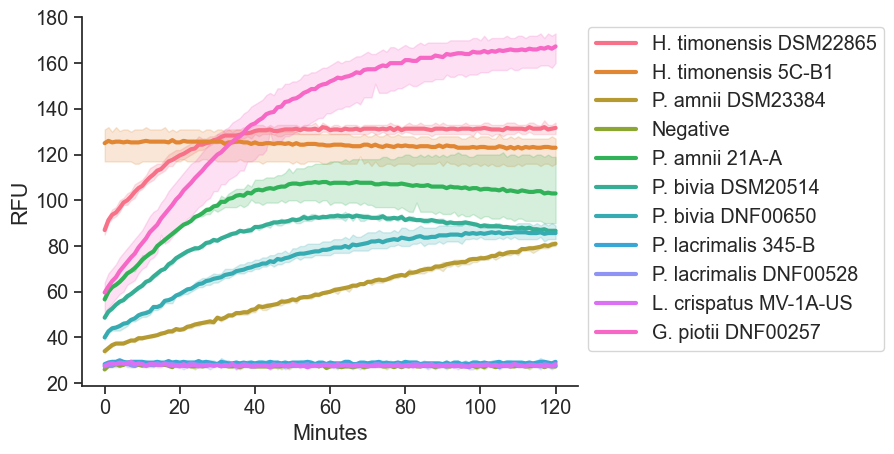

In [5]:
# Make a graph of all the isolates
sns.lineplot(data=df71924, x='Minutes', y='RFU', hue='Strain', linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

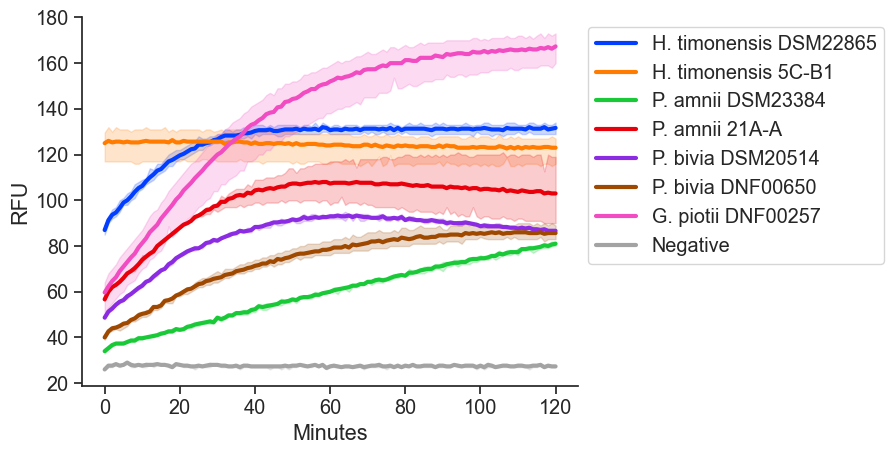

In [6]:
# Make a graph with just the isolates that were sialidase+
positives71924 = getSubsetDF(df71924, ['H. timonensis DSM22865', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DNF00650', 'G. piotii DNF00257', 'Negative'])
sns.lineplot(data=positives71924, x='Minutes', y='RFU', hue='Strain', linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

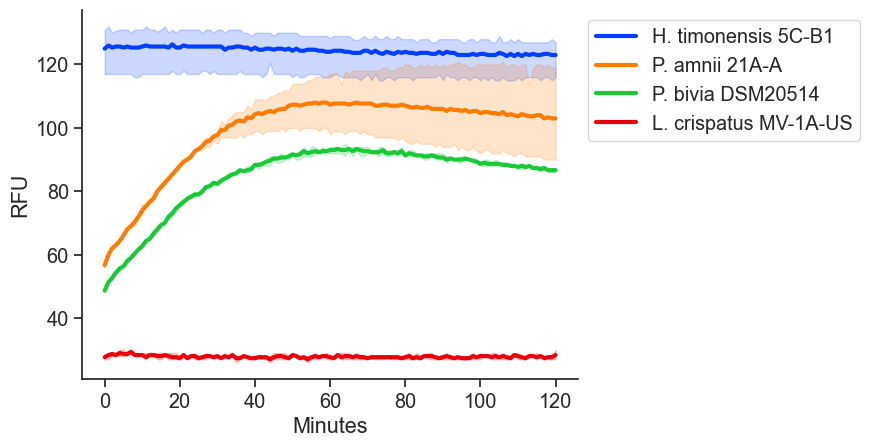

In [7]:
interestDF = getSubsetDF(df71924, ['H. timonensis 5C-B1', 'P. amnii 21A-A', 'P. bivia DSM20514', 'L. crispatus MV-1A-US'])
sns.lineplot(data=interestDF, x='Minutes', y='RFU', hue='Strain', linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

In [8]:
# Write out the average delta RFU value for each replicate of each isolate to the file "7-19-24_rates.csv"
calculateRFURates(df71924, 120, analysisPath.joinpath('7-19-24_rates.csv'))

In [9]:
# Load in the sialidase assay data and tell Python where the isolates were
data8724 = pd.read_csv(analysisPath.joinpath('8-7-24.csv'))
strains8724 = [
    ['', '', '', '', '', '', '', '', '', 'L. crispatus JV-V01', 'L. crispatus JV-V01','L. crispatus JV-V01'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066 (10x)', 'G. piotii JCP8066 (10x)', 'G. piotii JCP8066 (10x)', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['M. lornae 199-6', 'M. lornae 199-6', 'M. lornae 199-6', 'L. iners 60-B', 'L. iners 60-B', 'L. iners 60-B', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'Positive Control', 'Negative', 'Negative'],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '']
]
df8724 = sialidaseData2DF(data8724, strains8724)

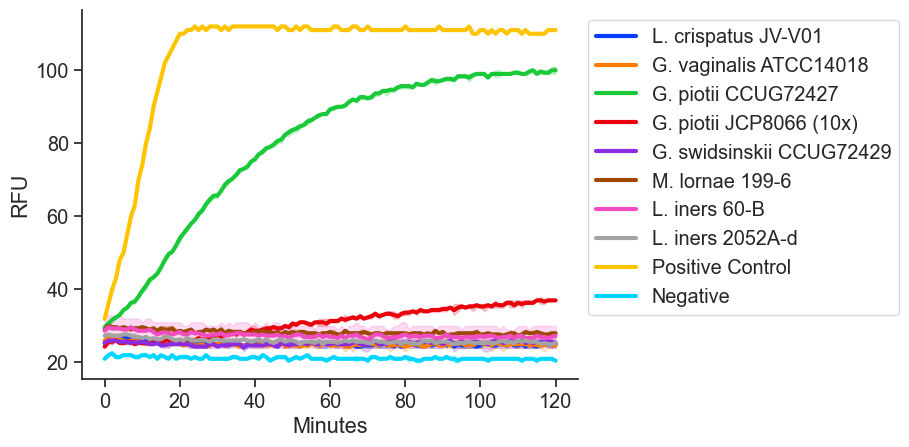

In [10]:
# Make a graph of all the isolates
sns.lineplot(data=df8724, x='Minutes', y='RFU', hue='Strain', linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

In [11]:
calculateRFURates(df8724, 120, analysisPath.joinpath('8-7-24_rates.csv'))

In [12]:
# Make a graph of the aggregate data
aggData = pd.read_csv(analysisPath.joinpath('aggregate_data.csv'))

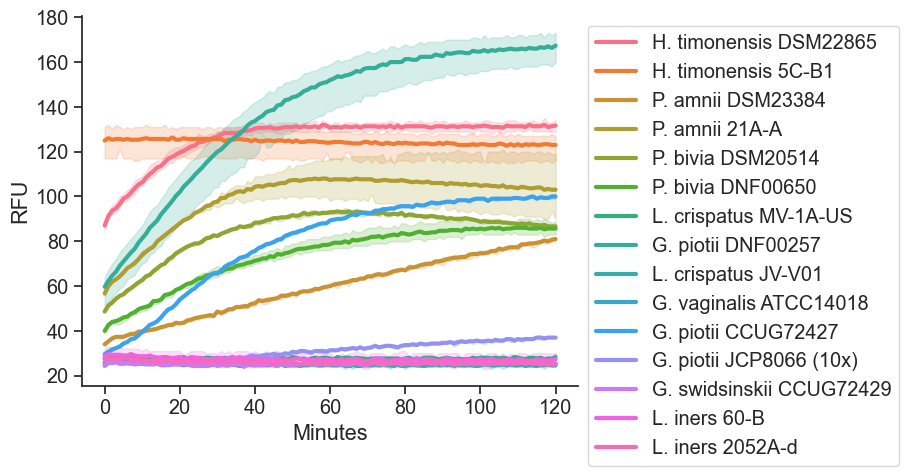

In [13]:
sns.lineplot(data=aggData, x='Minutes', y='RFU', hue='Strain', linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

In [14]:
rateData = pd.read_csv(analysisPath.joinpath('aggregate_rate_data.csv'))

C:\Users\emlee\AppData\Local\Temp\ipykernel_23072\3869653543.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(['$\it{H. timonensis}$ DSM22865', '$\it{P. amnii}$ DSM23384', '$\it{P. amnii}$ 21A-A', '$\it{P. bivia}$ DSM20514', '$\it{P. bivia}$ DNF00650', '$\it{G. piotii}$ CCUG72427', '$\it{G. piotii}$ JCP8066', '$\it{G. vaginalis}$ ATCC14018', '$\it{G. swidsinskii}$ CCUG72429', '$\it{P. lacrimalis}$ 345-B', '$\it{P. lacrimalis}$ DNF00528', '$\it{L. crispatus}$ MV-1A-US', '$\it{L. crispatus}$ JV-V01', '$\it{L. iners}$ 60-B', '$\it{L. iners}$ 2052A-d'], rotation=30, ha='right')


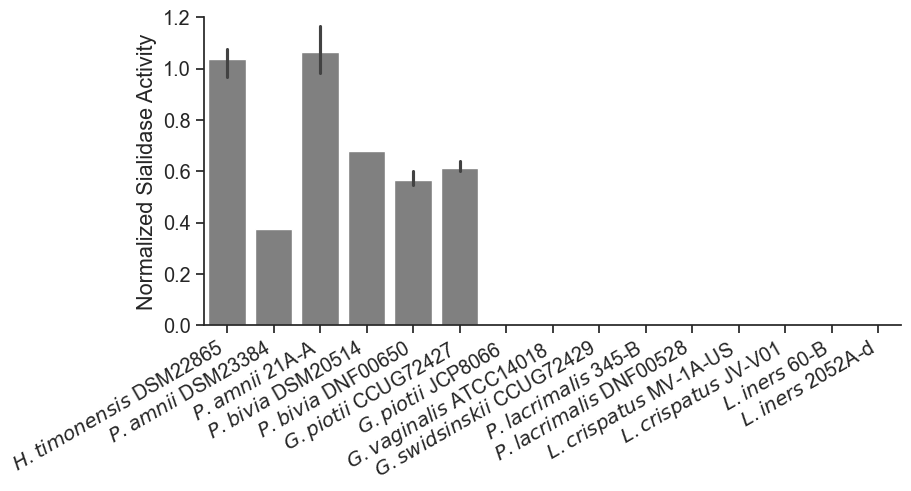

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))
plot = sns.barplot(ax=ax, data=rateData, x='Isolate', y='Report Rate', color='gray')
plot.set(ylabel='Normalized Sialidase Activity', xlabel='', ylim=(0, 1.2))
plot.set_xticklabels(['$\it{H. timonensis}$ DSM22865', '$\it{P. amnii}$ DSM23384', '$\it{P. amnii}$ 21A-A', '$\it{P. bivia}$ DSM20514', '$\it{P. bivia}$ DNF00650', '$\it{G. piotii}$ CCUG72427', '$\it{G. piotii}$ JCP8066', '$\it{G. vaginalis}$ ATCC14018', '$\it{G. swidsinskii}$ CCUG72429', '$\it{P. lacrimalis}$ 345-B', '$\it{P. lacrimalis}$ DNF00528', '$\it{L. crispatus}$ MV-1A-US', '$\it{L. crispatus}$ JV-V01', '$\it{L. iners}$ 60-B', '$\it{L. iners}$ 2052A-d'], rotation=30, ha='right')
sns.despine()
#saveFig(plot, figPath.joinpath('rates.png'))